# 1. Libraries and Loading data

In [ ]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

100%|██████████| 183M/183M [00:01<00:00, 141MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/black-box-attack/versions/1
TYPE
DB_FLT    243
DB_GNL    140
DB_SMS     21
Name: count, dtype: int64


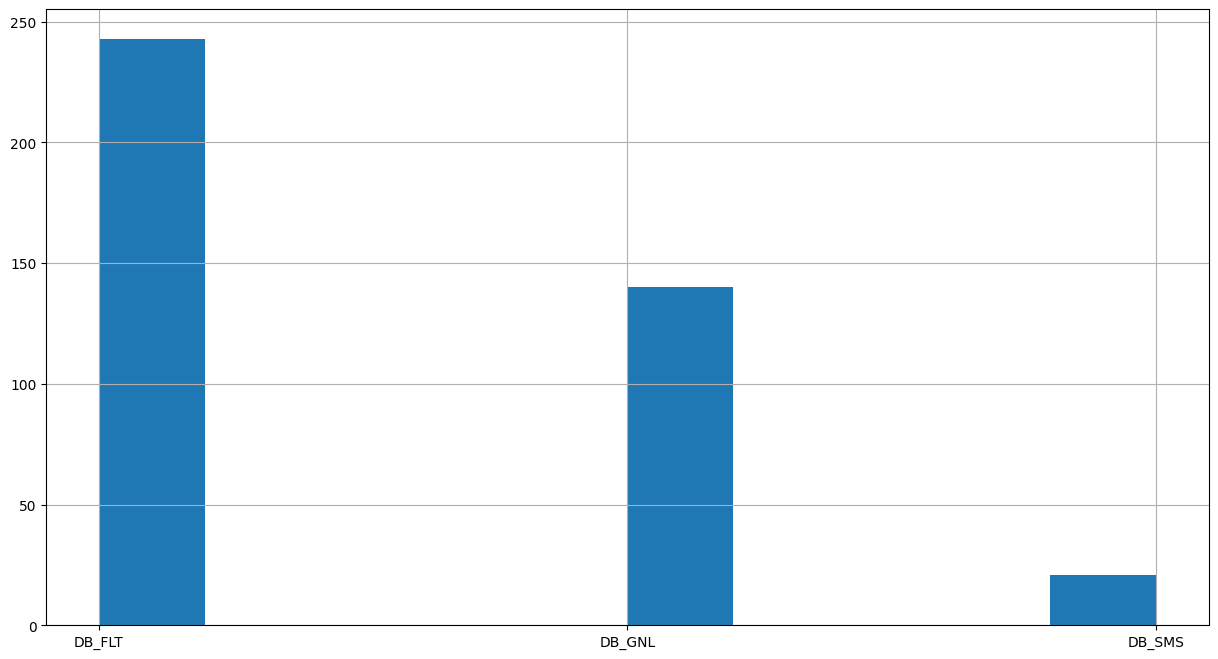

In [ ]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/black-box-attack")

print("Path to dataset files:", path)

Black_Box_Attack_Type_Main_Path = Path(os.path.join(path, "IMG_PMU_DATA_NT_VF_001"))
Attack_Path = list(Black_Box_Attack_Type_Main_Path.glob(r"*/*.jpg"))
Attack_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Attack_Path))

Attack_Path_Series = pd.Series(Attack_Path,name="JPG").astype(str)
Attack_Labels_Series = pd.Series(Attack_Labels,name="TYPE")

# Dataframe
Main_Attack_Data = pd.concat([Attack_Path_Series,Attack_Labels_Series],axis=1)
# Shuffle
Main_Attack_Data = Main_Attack_Data.sample(frac=1).reset_index()

print(Main_Attack_Data["TYPE"].value_counts())
Main_Attack_Data["TYPE"].hist(figsize=(15,8))
plt.style.use("dark_background")
plt.show()

In [ ]:
X_Train,X_Test = train_test_split(Main_Attack_Data,train_size=0.9,random_state=42,shuffle=True)
print(X_Train.shape)
print(X_Test.shape)


(363, 3)
(41, 3)


### Visualize images

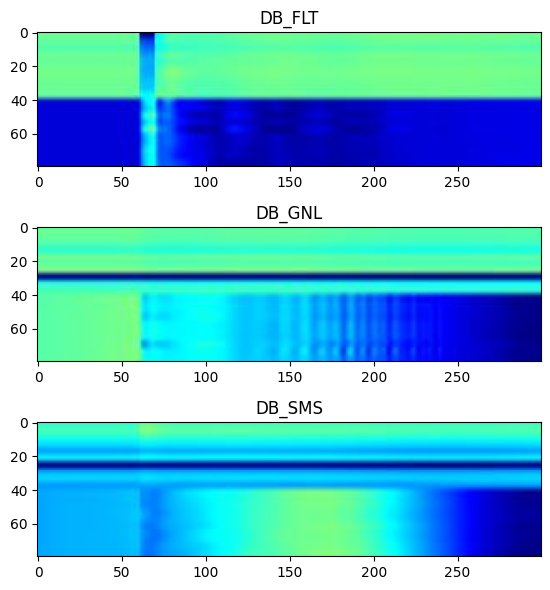

In [ ]:
import cv2
plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

num_images_per_class = 1
unique_types = Main_Attack_Data["TYPE"].unique()

fig, axes = plt.subplots(len(unique_types), num_images_per_class, figsize=(10, 2 * len(unique_types)))


for row_idx, attack_type in enumerate(unique_types):
    attack_images = Main_Attack_Data[Main_Attack_Data["TYPE"] == attack_type]["JPG"].iloc[:num_images_per_class]

    for col_idx, img_path in enumerate(attack_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[row_idx, col_idx] if num_images_per_class > 1 else axes[row_idx]
        ax.set_title(attack_type)
        #ax.set_xlabel(f"{img.shape}")
        #ax.set_ylabel(f"{img.size}")
        ax.imshow(img)

plt.tight_layout()
plt.show()

### Image generator

In [ ]:
Train_IMG_Generator = ImageDataGenerator(rescale=1./255,
                                        shear_range=0.3,
                                        zoom_range=0.3,
                                        rotation_range=25,
                                        brightness_range=[0.4,1.0],
                                        horizontal_flip=True,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,
                                        validation_split=0.1,
                                         channel_shift_range=0.3,
                                         fill_mode="nearest")
Test_IMG_Generator = ImageDataGenerator(rescale=1./255)

In [ ]:
Train_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=X_Train,
                                                   x_col="JPG",
                                                   y_col="TYPE",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   subset="training",
                                                   target_size=(80,300),
                                                    directory=Black_Box_Attack_Type_Main_Path)

Found 327 validated image filenames belonging to 3 classes.


In [ ]:
Validation_Set = Train_IMG_Generator.flow_from_dataframe(dataframe=X_Train,
                                                        x_col="JPG",
                                                        y_col="TYPE",
                                                        color_mode="rgb",
                                                        class_mode="categorical",
                                                        subset="validation",
                                                        target_size=(80,300),
                                                         directory=Black_Box_Attack_Type_Main_Path)

Found 36 validated image filenames belonging to 3 classes.


In [ ]:
Test_Set = Test_IMG_Generator.flow_from_dataframe(dataframe=X_Test,
                                                        x_col="JPG",
                                                        y_col="TYPE",
                                                        color_mode="rgb",
                                                        class_mode="categorical",
                                                        target_size=(80,300),
                                                  directory=Black_Box_Attack_Type_Main_Path)

Found 41 validated image filenames belonging to 3 classes.


In [ ]:
print("TRAIN: ")
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])

for data_batch,label_batch in Train_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

print("---"*20)
print("VALIDATION: ")
print(Validation_Set.class_indices)
print(Validation_Set.classes[0:5])

for data_batch,label_batch in Validation_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

print("---"*20)
print("TEST: ")
print(Test_Set.class_indices)
print(Test_Set.classes[0:5])

for data_batch,label_batch in Test_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

TRAIN: 
{'DB_FLT': 0, 'DB_GNL': 1, 'DB_SMS': 2}
[0, 0, 0, 0, 1]
DATA SHAPE:  (32, 80, 300, 3)
LABEL SHAPE:  (32, 3)
------------------------------------------------------------
VALIDATION: 
{'DB_FLT': 0, 'DB_GNL': 1, 'DB_SMS': 2}
[2, 0, 0, 0, 0]
DATA SHAPE:  (32, 80, 300, 3)
LABEL SHAPE:  (32, 3)
------------------------------------------------------------
TEST: 
{'DB_FLT': 0, 'DB_GNL': 1, 'DB_SMS': 2}
[1, 1, 0, 1, 1]
DATA SHAPE:  (32, 80, 300, 3)
LABEL SHAPE:  (32, 3)


# 2. Model comparison:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16, ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Flatten, Dense

# Customized CNN
def create_base_model():
    model = Sequential()

    # First Conv layer
    model.add(Conv2D(32, 3, activation="relu", input_shape=(80, 300, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2)))

    # Second Conv layer
    model.add(Conv2D(64, 3, activation="relu", padding="same"))
    model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2)))

    # Third Conv layer
    model.add(Conv2D(64, 3, activation="relu", padding="same"))
    model.add(Conv2D(128, 3, activation="relu", padding="same"))
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax"))

    return model

# ResNet50
def create_resnet50():
    base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(80, 300, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax")
    ])
    return model

# VGG16
def create_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(80, 300, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax")
    ])
    return model

models = {
    "Base_CNN": create_base_model(),
    "ResNet50": create_resnet50(),
    "VGG16": create_vgg16()
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import keras
from keras.utils import plot_model

for name, model in models.items():
  plot_model(model,to_file=name+".png",show_layer_names=True,show_dtype=True,show_shapes=True)

In [ ]:
# Callbacks
callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, mode="min"),
    tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy", save_best_only=True, filepath="./best_model.keras")
]

history_dict = {}

# Training
def train_and_store_history(model, name):
    print(f"\nEntrenando modelo: {name}\n")
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())  # Mostrar la arquitectura

    history = model.fit(Train_Set,
                        validation_data=Validation_Set,
                        epochs=50,
                        callbacks=callbacks)
    history_dict[name] = history.history

In [ ]:
train_and_store_history(models["Base_CNN"], "Base_CNN")


Entrenando modelo: Base_CNN



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 80, 300, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80, 300, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 150, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 150, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 150, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 150, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 75, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 274,819 (1.05 MB)

 Trainable params: 274,755 (1.05 MB)

 Non-trainable params: 64 (256.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5061 - loss: 1.0599 - val_accuracy: 0.6389 - val_loss: 1.0162
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.5400 - loss: 0.8689 - val_accuracy: 0.6389 - val_loss: 0.9985
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.5730 - loss: 0.8832 - val_accuracy: 0.6389 - val_loss: 1.0079
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.6169 - loss: 0.8195 - val_accuracy: 0.6667 - val_loss: 0.9930
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.6295 - loss: 0.8706 - val_accuracy: 0.5556 - val_loss: 1.0198
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.6864 - loss: 0.7654 - val_accuracy: 0.6111 - val_loss: 1.0190
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.6932 - loss: 0.7208 - val_accuracy: 0.6389 - val_loss: 0.9955
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7394 - loss: 0.6686 - val_accuracy: 0.61

In [ ]:
train_and_store_history(models["ResNet50"], "ResNet50")


Entrenando modelo: ResNet50



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 3, 10, 2048)         │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,090,115 (91.90 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

None
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5597 - loss: 1.3280 - val_accuracy: 0.8056 - val_loss: 0.5641
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7317 - loss: 0.7363 - val_accuracy: 0.8889 - val_loss: 0.3895
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.8193 - loss: 0.5448 - val_accuracy: 0.7778 - val_loss: 0.4658
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.8439 - loss: 0.3893 - val_accuracy: 0.8889 - val_loss: 0.2005
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.7655 - loss: 0.4792 - val_accuracy: 0.9167 - val_loss: 0.2191
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.8283 - loss: 0.4975 - val_accuracy: 0.8333 - val_loss: 0.3905
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.8470 - loss: 0.4215 - val_accuracy: 0.8611 - val_loss: 0.3050
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.8350 - loss: 0.4099 - val_accuracy:

In [ ]:
train_and_store_history(models["VGG16"], "VGG16")


Entrenando modelo: VGG16



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 9, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4717 - loss: 1.0533 - val_accuracy: 0.7500 - val_loss: 0.6160
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.6242 - loss: 0.7870 - val_accuracy: 0.7222 - val_loss: 0.6285
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.6588 - loss: 0.7531 - val_accuracy: 0.7778 - val_loss: 0.5336
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.7248 - loss: 0.6786 - val_accuracy: 0.8333 - val_loss: 0.4723
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.7478 - loss: 0.5844 - val_accuracy: 0.7778 - val_loss: 0.4672
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.7500 - loss: 0.5977 - val_accuracy: 0.8333 - val_loss: 0.4452
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.7896 - loss: 0.5730 - val_accuracy: 0.8056 - val_loss: 0.3937
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.8029 - loss: 0.4813 - val_accuracy:

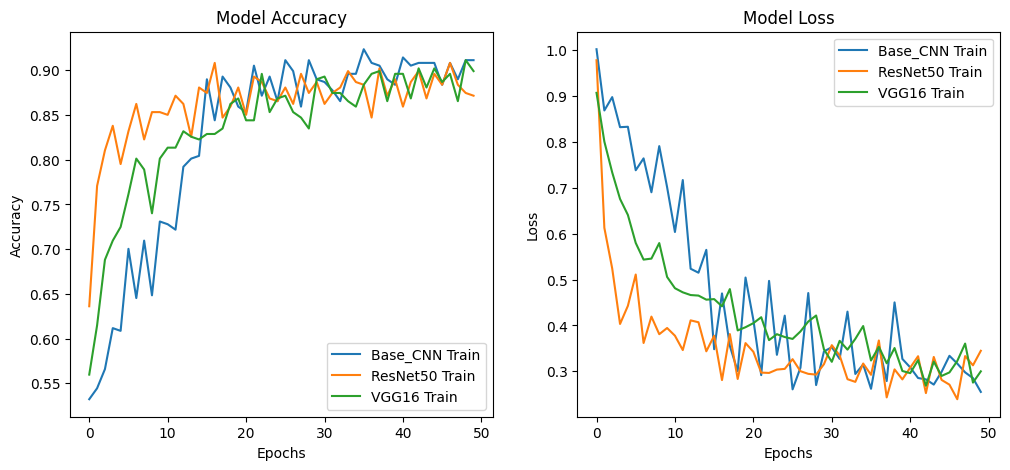

In [ ]:
plt.figure(figsize=(12, 5))

#if we want plot to be white instead of black background
plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Accuracy graph
plt.subplot(1, 2, 1)
for name, history in history_dict.items():
    plt.plot(history["accuracy"], label=f"{name} Train")
    #plt.plot(history["val_accuracy"], label=f"{name} Val", linestyle="dashed")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
for name, history in history_dict.items():
    plt.plot(history["loss"], label=f"{name} Train")
    #plt.plot(history["val_loss"], label=f"{name} Val", linestyle="dashed")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# 3. Other code

## Model

In [ ]:
model = Sequential()

# First Conv layer
model.add(Conv2D(32, 3, activation="relu", input_shape=(80, 300, 3), padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2)))

# Second Conv layer
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2)))

# Third Conv layer
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation="softmax"))

In [ ]:
print(model.summary())

## Training, loss and accuracy

In [ ]:
import tensorflow as tf

Call_Back_Early_Stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Call_Back_Check = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                     save_best_only=True,
                                                     filepath="./my_model.keras")

model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

CNN_Model = model.fit(Train_Set,
                      validation_data=Validation_Set,
                      callbacks=[Call_Back_Early_Stop,Call_Back_Check],
                      epochs=50)

In [ ]:
Model_Results = model.evaluate(Test_Set)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

plt.plot(CNN_Model.history["loss"])
plt.plot(CNN_Model.history["accuracy"])
plt.ylabel("LOSS - ACCURACY")
plt.legend()
plt.show()